In [3]:
%pylab inline
import numpy as np
import matplotlib 
import tensorflow as tf
from tqdm import trange
from keras.datasets import mnist
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
(X_train, Y_train), (X_test, Y_test) =  mnist.load_data()

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.tanh(self.l1(x))
    
    x = self.l2(x)
    x = self.sm(x)

    return x

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\varch\anaconda3\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
loss 0.61 accuracy 0.87: 100%|██████████| 1000/1000 [00:16<00:00, 62.33it/s]


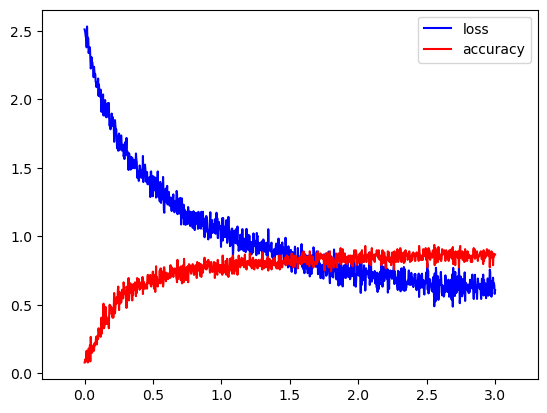

In [6]:
# training
model = BobNet()

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  

x = np.linspace(0, 3, 1000)
fig, ax = plt.subplots()
ax.plot(x, losses, '-b', label='loss')
ax.plot(x, accuracies, '-r', label='accuracy')
ax.axis('equal')
leg = ax.legend();

In [5]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()


0.8598

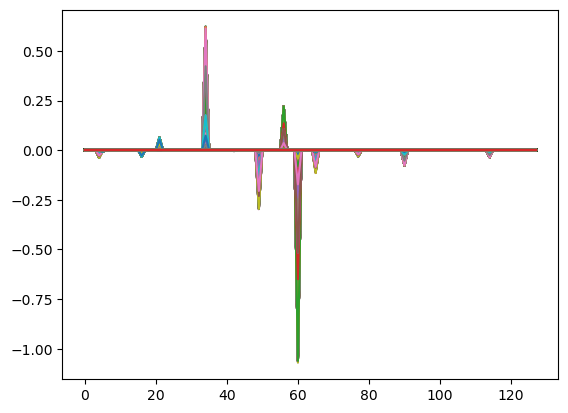

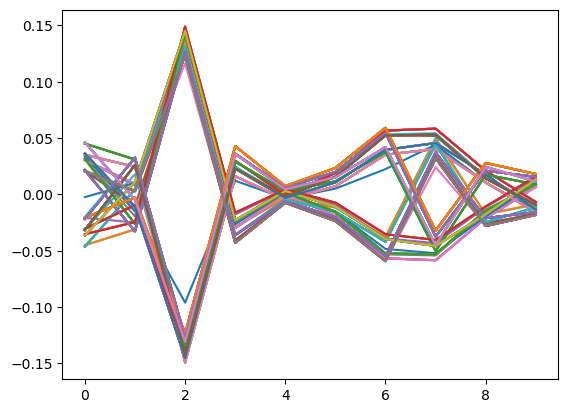

In [6]:
#computing gradients
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
plot(model.l1.weight.grad)
figure()
plot(model.l2.weight.grad)


In [7]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x

def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

numpy_eval()

0.7503

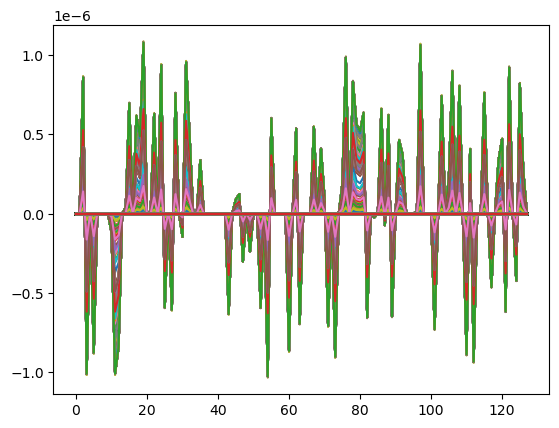

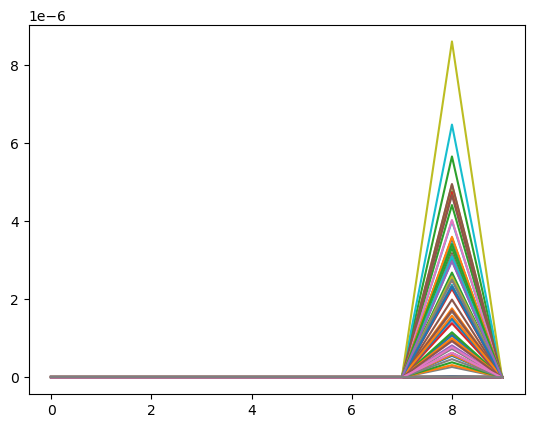

In [8]:
# numpy forward and backward pass

def logsumexp(x):
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # training
  out = np.zeros((len(y),10), np.float32)
  out[range(out.shape[0]),y] = 1

  # forward pass
  x_l1 = x.dot(l1)
  x_tanh = np.maximum(x_l1, 0)
  x_l2 = x_tanh.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)

  # training in numpy 
  # backward pass

  d_out = -out / len(y)
  dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
  d_l2 = x_tanh.T.dot(dx_lsm)
  dx_tanh = dx_lsm.dot(l2.T)

  # derivative of tanh
  dx_l1 = (x_tanh > 0).astype(np.float32) * dx_tanh

  # derivative of l1
  d_l1 = x.T.dot(dx_l1)
  
  return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

plot(d_l1.T)
figure()
plot(d_l2.T)

loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:02<00:00, 428.72it/s]


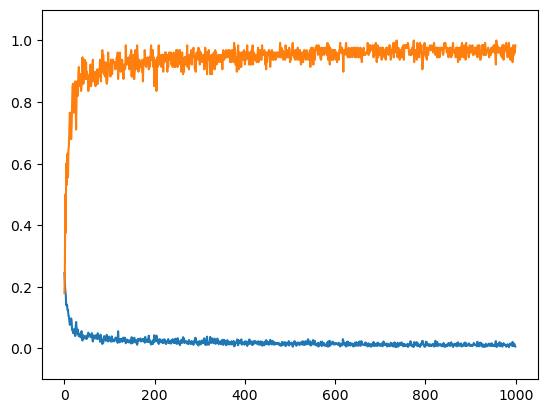

In [9]:
# numpy training
def layer_init(m, h):
  # gaussian is strong
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()
  
  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [10]:
numpy_eval()

0.9635

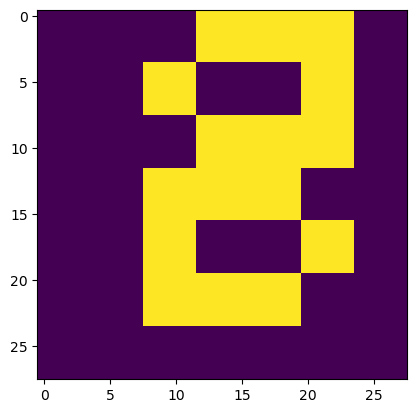

In [11]:
#test run
m = [[0,0,0,1,1,1,0],
     [0,0,1,0,0,1,0],
     [0,0,0,1,1,1,0],
     [0,0,1,1,1,0,0],
     [0,0,1,0,0,1,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))

In [ ]:
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x)

8

In [2]:
model.save('BobNet.hdf5')

NameError: name 'model' is not defined